In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np

In [2]:
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
import numpy.matlib

In [3]:
from sklearn.model_selection import StratifiedKFold
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop, Adam
from keras.models import Model
from keras.layers.embeddings import Embedding
from keras.layers import Flatten,Input,concatenate

Using TensorFlow backend.


In [4]:
! dir

embeddingNNHackathon.ipynb  Forth_try.csv		   test_fjtUOL8.csv
Final_try.csv		    sample_submission_HSqiq1Q.csv  Third_try.csv
First_try.csv		    Second_try.csv		   train_fNxu4vz.csv


In [5]:
data_train = pd.read_csv('train_fNxu4vz.csv')
data_sub = pd.read_csv('test_fjtUOL8.csv')

In [6]:
data_sub.head()

,Loan_ID,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender
0,10164310,"27,500",10+ years,Mortgage,129000.0,VERIFIED - income,debt_consolidation,12.87,0,68.0,10,37,Male
1,10164311,"26,000",10+ years,NaN,110000.0,not verified,credit_card,11.37,0,NaN,6,23,Male
2,10164312,"6,075",< 1 year,Rent,75000.0,VERIFIED - income,debt_consolidation,6.83,2,NaN,5,20,Male
3,10164313,"12,000",10+ years,Mortgage,73000.0,VERIFIED - income source,debt_consolidation,7.76,0,NaN,6,8,Male
4,10164314,"35,000",< 1 year,Mortgage,156000.0,not verified,debt_consolidation,9.62,0,26.0,9,21,Male


In [7]:
min_max_scalerL = preprocessing.MinMaxScaler()
data_train['Loan_Amount_Requested'] = min_max_scalerL.fit_transform( data_train['Loan_Amount_Requested'].str.replace(',','').astype(int).values.reshape(-1, 1) )

data_sub['Loan_Amount_Requested'] = min_max_scalerL.transform( data_sub['Loan_Amount_Requested'].str.replace(',','').astype(int).values.reshape(-1, 1) )

In [8]:
min_max_scalerA = preprocessing.MinMaxScaler()
data_train['Annual_Income'] = min_max_scalerA.fit_transform( data_train['Annual_Income'].fillna(-1).values.reshape(-1, 1) )

data_sub['Annual_Income'] = min_max_scalerA.transform( data_sub['Annual_Income'].fillna(-1).values.reshape(-1, 1) )

min_max_scalerD = preprocessing.MinMaxScaler()
data_train['Debt_To_Income'] = min_max_scalerD.fit_transform( data_train['Debt_To_Income'].fillna(-1).values.reshape(-1, 1) )

data_sub['Debt_To_Income'] = min_max_scalerD.transform( data_sub['Debt_To_Income'].fillna(-1).values.reshape(-1, 1) )

min_max_scalerI = preprocessing.MinMaxScaler()
data_train['Inquiries_Last_6Mo'] = min_max_scalerI.fit_transform(  data_train['Inquiries_Last_6Mo'].fillna(-1).values.reshape(-1, 1) )

data_sub['Inquiries_Last_6Mo'] = min_max_scalerI.transform(  data_sub['Inquiries_Last_6Mo'].fillna(-1).values.reshape(-1, 1) )

min_max_scalerM = preprocessing.MinMaxScaler()
data_train['Months_Since_Deliquency'] = min_max_scalerM.fit_transform( data_train['Months_Since_Deliquency'].fillna(-1).values.reshape(-1, 1))

data_sub['Months_Since_Deliquency'] = min_max_scalerM.transform( data_sub['Months_Since_Deliquency'].fillna(-1).values.reshape(-1, 1))

min_max_scalerN = preprocessing.MinMaxScaler()
data_train['Number_Open_Accounts'] = min_max_scalerN.fit_transform( data_train['Number_Open_Accounts'].fillna(-1).values.reshape(-1, 1) )

data_sub['Number_Open_Accounts'] = min_max_scalerN.transform( data_sub['Number_Open_Accounts'].fillna(-1).values.reshape(-1, 1) )

min_max_scalerT = preprocessing.MinMaxScaler()
data_train['Total_Accounts'] = min_max_scalerT.fit_transform(  data_train['Total_Accounts'].fillna(-1).values.reshape(-1, 1) )

data_sub['Total_Accounts'] = min_max_scalerT.transform(  data_sub['Total_Accounts'].fillna(-1).values.reshape(-1, 1) )

In [9]:
# gender
data_train['Gender'] =  data_train['Gender'].str.replace('Male','1')
data_train['Gender'] =  data_train['Gender'].str.replace('Female','0')
data_train['Gender']  = data_train['Gender'] .astype(int)

data_sub['Gender'] =  data_sub['Gender'].str.replace('Male','1')
data_sub['Gender'] =  data_sub['Gender'].str.replace('Female','0')
data_sub['Gender']  = data_sub['Gender'] .astype(int)

In [10]:
di = {'not verified': 0, 'VERIFIED - income': 0.5,'VERIFIED - income source':1 }

data_train['Income_Verified'] = data_train['Income_Verified'].map(di)

data_sub['Income_Verified'] = data_sub['Income_Verified'].map(di)

In [11]:
dit = {'< 1 year': 0, '1 year': 0.1,'2 years': 0.2,'3 years': 0.3,'4 years': 0.4,'5 years': 0.5,'6 years': 0.6,'7 years': 0.7,'8 years': 0.8,'9 years': 0.9,'10+ years': 1}

data_train['Length_Employed'] = data_train['Length_Employed'].map(dit)

data_train['Length_Employed'] = data_train['Length_Employed'].fillna(-1)

data_sub['Length_Employed'] = data_sub['Length_Employed'].map(dit)

data_sub['Length_Employed'] = data_sub['Length_Employed'].fillna(-1)

In [12]:
dih = {'Own': 1, 'Mortgage': 0.75,'Rent': 0.5,'Other':0.25,'None':0}

data_train['Home_Owner'] = data_train['Home_Owner'].map(dih)
data_train['Home_Owner'] = data_train['Home_Owner'].fillna(-1)

data_sub['Home_Owner'] = data_sub['Home_Owner'].map(dih)
data_sub['Home_Owner'] = data_sub['Home_Owner'].fillna(-1)

In [13]:
lb_make = LabelEncoder()
data_train["Purpose_Of_Loan"] = lb_make.fit_transform(data_train["Purpose_Of_Loan"])

data_sub["Purpose_Of_Loan"] = lb_make.transform(data_sub["Purpose_Of_Loan"])

In [14]:
data_train.head()

,Loan_ID,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate
0,10000001,0.188406,0.0,0.50,0.009067,0.0,0,0.459365,0.000,0.000000,0.118421,0.077922,0,1
1,10000002,0.855072,0.4,0.75,0.000000,0.5,2,0.373343,0.000,0.099448,0.157895,0.142857,0,3
2,10000003,0.702174,0.7,0.75,0.010076,1.0,2,0.397099,0.000,0.000000,0.157895,0.090909,1,3
3,10000004,0.449275,0.0,-1.00,0.007488,1.0,2,0.358590,0.375,0.000000,0.210526,0.129870,1,3
4,10000005,0.478261,0.8,1.00,0.012800,1.0,2,0.554389,0.125,0.000000,0.250000,0.181818,0,1


In [15]:
data_sub.head()

,Loan_ID,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender
0,10164310,0.782609,1.0,0.75,0.017200,0.5,2,0.321830,0.00,0.381215,0.131579,0.227273,1
1,10164311,0.739130,1.0,-1.00,0.014667,0.0,1,0.284321,0.00,0.000000,0.078947,0.136364,1
2,10164312,0.161594,0.0,0.50,0.010000,0.5,2,0.170793,0.25,0.000000,0.065789,0.116883,1
3,10164313,0.333333,1.0,0.75,0.009733,1.0,2,0.194049,0.00,0.000000,0.078947,0.038961,1
4,10164314,1.000000,0.0,0.75,0.020800,0.0,2,0.240560,0.00,0.149171,0.118421,0.123377,1


In [16]:
data_train.Purpose_Of_Loan.unique()

array([ 0,  2,  1,  4,  6,  9,  7, 11,  8, 13, 12,  5,  3, 10])

In [17]:
# test train data

In [18]:
skf = StratifiedKFold(n_splits=5,random_state=42, shuffle=True)

In [19]:
X = data_train[['Loan_Amount_Requested','Annual_Income','Debt_To_Income','Inquiries_Last_6Mo','Months_Since_Deliquency','Number_Open_Accounts','Total_Accounts','Gender','Income_Verified','Length_Employed','Home_Owner']].values
y = data_train['Interest_Rate'].values
X2 = data_train[['Purpose_Of_Loan']].values


P = data_sub[['Loan_Amount_Requested','Annual_Income','Debt_To_Income','Inquiries_Last_6Mo','Months_Since_Deliquency','Number_Open_Accounts','Total_Accounts','Gender','Income_Verified','Length_Employed','Home_Owner']].values
P2 = data_sub[['Purpose_Of_Loan']].values

b = [] # append results
                
for train_index, test_index in skf.split(X, y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index,:], X[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    
    X2_train,X2_test = X2[train_index], X2[test_index]
    
    Y_train = np.zeros([len(y_train),3])
    for n in np.arange(len(y_train)):
        Y_train[n,y_train[n]-1] = 0.95
    
    
    Y_test = np.zeros([len(y_test),3])
    for n in np.arange(len(y_test)):
        Y_test[n,y_test[n]-1] = 0.95
        
        
    # keras simple MLP
    X_train.shape
    
    batch_size = 128
    num_classes = 3
    epochs = 400

    m = 14 #len(data_train.Purpose_Of_Loan.unique())
    embedding_size = int(min(50, (m+1)/ 2))
    
    x = Input(shape=(1,),name='input')
    meta_data = Input(shape=(11,),name='meta')
    x1 = Embedding(input_dim = m, output_dim = embedding_size, input_length = 1, name="embedding")(x)
    x2 = Flatten()(x1)
    x3 = Dense(50, activation="tanh")(x2)
    x4 = Dense(15, activation="tanh")(x3)

    x5 = concatenate([x4,meta_data])
    x6 = Dense(1000, activation='tanh')(x5)
    x7 = Dropout(0.2)(x6)
    x8 = Dense(200, activation='tanh')(x7)
    x9 = Dropout(0.2)(x8)
    x10 = Dense(100, activation='tanh')(x9)
    x11 = Dropout(0.2)(x10)
    out = Dense(3, activation='softmax')(x11)

    opt = keras.optimizers.Adam(learning_rate=0.00025)

    modelee = Model(inputs=[x,meta_data], outputs=out)
    modelee.compile(loss = 'mean_squared_logarithmic_error', optimizer = opt, metrics=["accuracy"])  #optimizer=opt,'mse',"mean_squared_logarithmic_error"
    
    classWeights = (len(Y_train) - (np.sum(Y_train,axis = 0) ) )/ len(Y_train)
    classWeights = np.matlib.repmat( classWeights, len(Y_train), 1)
    classWeights = np.max(classWeights*Y_train,axis=1)

    modelee.fit(x = [X2_train,X_train], y= Y_train , epochs = epochs, batch_size = batch_size,validation_data=([X2_test,X_test], Y_test),sample_weight=classWeights)
    
    out = modelee.predict([X2_test,X_test])
    out2 = np.argmax(out,axis=1)
    print(f1_score(y_test, out2+1, average='weighted'))
    
    out = modelee.predict([P2,P])
    
    b.append(out)

/home/douglas/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 131447 samples, validate on 32862 samples
Epoch 1/400
131447/131447 [==============================] - 9s 69us/step - loss: 0.0593 - accuracy: 0.4825 - val_loss: 0.0922 - val_accuracy: 0.5008
Epoch 2/400
131447/131447 [==============================] - 5s 37us/step - loss: 0.0586 - accuracy: 0.4937 - val_loss: 0.0922 - val_accuracy: 0.5023
Epoch 3/400
131447/131447 [==============================] - 5s 37us/step - loss: 0.0585 - accuracy: 0.4982 - val_loss: 0.0919 - val_accuracy: 0.5039
Epoch 4/400
131447/131447 [==============================] - 5s 37us/step - loss: 0.0585 - accuracy: 0.4967 - val_loss: 0.0926 - val_accuracy: 0.4958
Epoch 5/400
131447/131447 [==============================] - 5s 38us/step - loss: 0.0584 - accuracy: 0.4974 - val_loss: 0.0927 - val_accuracy: 0.4923
Epoch 6/400
131447/131447 [==============================] - 5s 37us/step - loss: 0.0584 - accuracy: 0.4981 - val_loss: 0.0920 - val_accuracy: 0.5008
Epoch 7/400
131447/131447 [======================

Epoch 55/400
131447/131447 [==============================] - 5s 37us/step - loss: 0.0563 - accuracy: 0.5196 - val_loss: 0.0891 - val_accuracy: 0.5210
Epoch 56/400
131447/131447 [==============================] - 5s 37us/step - loss: 0.0563 - accuracy: 0.5185 - val_loss: 0.0892 - val_accuracy: 0.5205
Epoch 57/400
131447/131447 [==============================] - 5s 38us/step - loss: 0.0563 - accuracy: 0.5185 - val_loss: 0.0889 - val_accuracy: 0.5219
Epoch 58/400
131447/131447 [==============================] - 5s 37us/step - loss: 0.0563 - accuracy: 0.5200 - val_loss: 0.0897 - val_accuracy: 0.5147
Epoch 59/400
131447/131447 [==============================] - 5s 37us/step - loss: 0.0563 - accuracy: 0.5192 - val_loss: 0.0894 - val_accuracy: 0.5183
Epoch 60/400
131447/131447 [==============================] - 5s 38us/step - loss: 0.0562 - accuracy: 0.5189 - val_loss: 0.0892 - val_accuracy: 0.5198
Epoch 61/400
131447/131447 [==============================] - 5s 37us/step - loss: 0.0563 - ac

KeyboardInterrupt: 

In [33]:
    out = modelee.predict([X2_test,X_test])
    out2 = np.argmax(out,axis=1)
    print(f1_score(y_test, out2+1, average='weighted'))
    
    out = modelee.predict([P2,P])
    
    b.append(out)

0.5226243336368355


In [34]:
from scipy import stats

#stats.mode(nums)

In [35]:
h = []
for n in np.arange(5):
    h.append( np.argmax( b[n],axis=1) )

In [36]:
h = np.array(h)

In [37]:
fk = stats.mode(h)

In [38]:
submission = data_sub['Loan_ID'].values

In [39]:
submissao = pd.DataFrame()# out2

In [40]:
submissao['Loan_ID'] = submission
submissao['Interest_Rate'] = fk[0][0] +1

In [41]:
submissao.to_csv('Final_try.csv',index=False)

In [42]:
submissao

,Loan_ID,Interest_Rate
0,10164310,2
1,10164311,1
2,10164312,3
3,10164313,2
4,10164314,3
...,...,...
109536,10273846,3
109537,10273847,1
109538,10273848,2
109539,10273849,3


# Rascunho

In [47]:
#out = modelee.predict([P2,P])

In [27]:
#b.append(out)

In [49]:
out = modelee.predict([X2_test,X_test])

In [52]:
out2 = np.argmax(out,axis=1)
print(np.sum(out2==0))
print(np.sum(out2==1))
print(np.sum(out2==2))

6965
11843
14054


In [53]:
print(np.sum(y_test==1))
print(np.sum(y_test==2))
print(np.sum(y_test==3))

6762
14116
11984


In [54]:
f1_score(y_test, out2+1, average='weighted')

0.5082978856415952

In [55]:
from sklearn.metrics import classification_report

In [57]:
print(classification_report(y_test, out2+1, labels=[1, 2, 3]))

              precision    recall  f1-score   support

           1       0.44      0.45      0.44      6762
           2       0.52      0.43      0.47     14116
           3       0.54      0.64      0.59     11984

    accuracy                           0.51     32862
   macro avg       0.50      0.51      0.50     32862
weighted avg       0.51      0.51      0.51     32862



In [20]:
layer = modelee.get_layer('embedding')
output_embeddings = layer.get_weights()
output_embeddings

[array([[-1.48892000e-01,  3.63231450e-02,  6.83993921e-02,
          1.41502276e-01,  3.53250690e-02, -1.21060617e-01,
          8.13833550e-02],
        [-6.14048168e-02,  1.41045228e-01, -5.98349795e-02,
          5.47565930e-02, -6.00459054e-02, -1.82451122e-02,
          9.90423039e-02],
        [ 5.40578680e-04,  1.37783205e-02, -2.92929541e-02,
         -9.19383392e-02, -8.65486730e-03,  1.41530363e-02,
          1.27138458e-02],
        [-3.00475717e-01,  3.38320881e-01, -3.86669874e-01,
         -5.36271155e-01, -2.17615500e-01, -6.64056093e-02,
          8.61872435e-01],
        [-5.40018529e-02, -3.97217050e-02,  5.00009544e-02,
         -4.82027754e-02, -1.02226391e-01, -4.38811816e-02,
          4.51488839e-03],
        [ 1.31283496e-02, -4.75411303e-02, -1.01003004e-02,
          1.13168932e-01,  7.20300749e-02, -1.05975747e-01,
         -2.31563628e-01],
        [-1.08338624e-01, -6.30173041e-03,  4.25236970e-02,
          8.86554718e-02, -8.23564604e-02, -1.65286079e-01

In [29]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [26]:
 X_embedded = TSNE(n_components=2).fit_transform(output_embeddings[0])

In [28]:
X_embedded

array([[-127.35968 ,  224.29552 ],
       [-107.8652  ,  -84.027145],
       [  46.91374 , -110.12073 ],
       [  96.07201 , -276.06717 ],
       [ 229.18227 ,  195.28246 ],
       [-236.47746 ,   72.10942 ],
       [ -93.869125, -257.25983 ],
       [ 231.7603  , -147.70546 ],
       [  60.353844,  152.38705 ],
       [  49.32772 ,  316.06815 ],
       [-266.7645  , -124.34752 ],
       [ 309.0916  ,   22.246988],
       [ 136.08078 ,   14.883256],
       [ -54.76361 ,   56.27914 ]], dtype=float32)

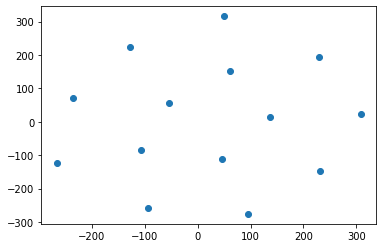

In [34]:
plt.scatter(X_embedded[:,0], X_embedded[:,1])
plt.show()

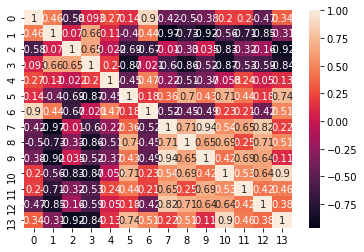

In [45]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

data =pd.DataFrame( output_embeddings[0].T )


corrMatrix = data.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [44]:
data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-0.148892,-0.061405,0.000541,-0.300476,-0.054002,0.013128,-0.108339,0.065848,0.295120,0.127086,0.006399,0.033204,0.154548,-0.007609
1,0.036323,0.141045,0.013778,0.338321,-0.039722,-0.047541,-0.006302,-0.119929,-0.109378,-0.131912,-0.154940,-0.168335,-0.220402,-0.145264
2,0.068399,-0.059835,-0.029293,-0.386670,0.050001,-0.010100,0.042524,0.083935,0.057898,0.081423,0.110423,0.318735,0.153883,0.192505
3,0.141502,0.054757,-0.091938,-0.536271,-0.048203,0.113169,0.088655,-0.031383,0.212501,-0.051571,0.204307,-0.019118,0.054746,0.342787
4,0.035325,-0.060046,-0.008655,-0.217616,-0.102226,0.072030,-0.082356,0.135557,0.211629,0.235229,0.061276,0.189437,0.063406,-0.058877
5,-0.121061,-0.018245,0.014153,-0.066406,-0.043881,-0.105976,-0.165286,0.084400,0.255772,0.040685,0.034372,-0.142913,0.217664,-0.072077
6,0.081383,0.099042,0.012714,0.861872,0.004515,-0.231564,0.010213,-0.071560,-0.276647,-0.076277,-0.120550,-0.085395,-0.037603,-0.239727


In [ ]:
Y_train = np.zeros([len(y_test),3])
for n in np.arange(len(y_test)):
    Y_train[n,y_test[n]-1] = 1

In [ ]:
Y_train

In [ ]:
p = data_train['Loan_Amount_Requested'].str.replace(',','').astype(int)

In [ ]:
min(p)

In [ ]:
data_train[['Loan_Amount_Requested','Annual_Income']].values

In [ ]:
X

In [ ]:
data_train.dtypes

In [ ]:
data_train

In [ ]:
classWeights = 1/ ( np.sum(Y_train,axis = 0)/ len(Y_train) )

In [ ]:
np.log(classWeights+np.e)

In [ ]:
np.repmatclassWeights

In [ ]:
np.matlib.repmat(classWeights, 2, 1)

In [ ]:
classWeights

In [ ]:
y_train

In [ ]:
np.log(np.e)

In [ ]:
1/ (np.sum(Y_train,axis = 0)/ len(Y_train))

In [ ]:
j = (len(Y_train) /(np.sum(Y_train,axis = 0)) )

j = j/ np.sum(j)
#np.log (j+np.e)

In [ ]:
np.log(j+1)

In [ ]:
j+0.5

In [ ]:
classWeights = (len(Y_train) - (np.sum(Y_train,axis = 0) ) )/ len(Y_train)

In [ ]:
classWeights

In [ ]:
data_train["Purpose_Of_Loan"].head()

In [ ]:
m = len(data_train.Purpose_Of_Loan.unique())
embedding_size = int(min(50, m+1/ 2))


modele = Sequential()
modele.add(Embedding(input_dim = m, output_dim = embedding_size, input_length = 1, name="embedding"))
modele.add(Flatten())
modele.add(Dense(50, activation="relu"))
modele.add(Dense(15, activation="relu"))
modele.add(Dense(3, activation='softmax'))

modele.compile(loss = "mse", optimizer = "adam", metrics=["accuracy"])


In [ ]:
yy = np.c_[ data_train['Interest_Rate'] == 1,data_train['Interest_Rate'] == 2, data_train['Interest_Rate'] == 3]*0.95

In [ ]:
modele.fit(x = data_train["Purpose_Of_Loan"].values, y= yy , epochs = 50, batch_size = 4)

In [ ]:
x = Input(shape=(1,),name='input')
meta_data = Input(shape=(11,),name='meta')
x1 = Embedding(input_dim = m, output_dim = embedding_size, input_length = 1, name="embedding")(x)
x2 = Flatten()(x1)
x3 = Dense(50, activation="relu")(x2)
x4 = Dense(15, activation="relu")(x3)

x5 = concatenate([x4,meta_data])
x6 = Dense(100, activation='sigmoid')(x5)
x7 = Dense(100, activation='sigmoid')(x6)

out = Dense(3, activation='softmax')(x7)

modelee = Model(inputs=[x,meta_data], outputs=out)
modelee.compile(loss = "mse", optimizer = "adam", metrics=["accuracy"])

In [ ]:
modelee.fit(x = data_train["Purpose_Of_Loan"].values, y= yy , epochs = 50, batch_size = 4)

In [ ]:
layer = modele.get_layer('embedding')
output_embeddings = layer.get_weights()
output_embeddings

In [ ]:
m

In [ ]:
modele.predict(data_train["Purpose_Of_Loan"].values)

In [ ]:
embedding_size = int(min(50, m+1/ 2))

In [ ]:
embedding_size

In [ ]:
 m+1/ 2